# LSTM과 GRU 셀
- 순환 신경망에서 매우 중요한 기술
- LSTM과 GRU셀은 SimpleRNN보다 계산이 복잡하지만 성능이 뛰어남
- 일반적으로 기본 순환층은 긴 시퀀스(긴 문장)를 학습하기 어려움
- 시퀀스가 길어질 수록 순환되는 은닉 상태에 담긴 정보가 점점 희석됨
- 이를 보완하기 위해 LSTM과 GRU셀이 발명되었음

## LSTM(Long Short-Term Memory) 구조
- 기본적인 순환 신경망은 마치 단기기억과 같은 개념
- 장기기억 개념을 표현하기 위해 고안된 방식
- 기본적으로 입력에 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 가지며 결과는 다음 타임스텝에 재사용 됨

#### 은닉 상태를 만드는 방법
- 은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만듦
- 기본 순환층과 다르게 시그모이드 활성화 함수를 사용하며 tanh 활성화 함수를 통과한 <b>어떤 값</b>과 곱해서 은닉 상태를 만듦
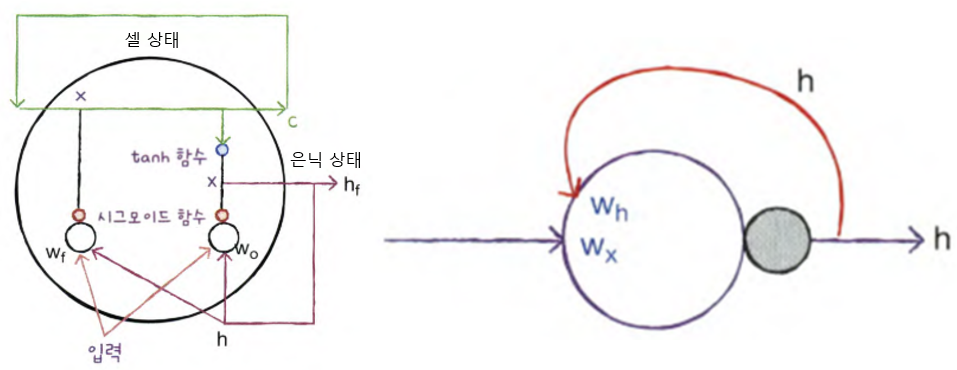
- 은닉 상태를 계산할 때 사용하는 가중치 $W_x와 W_h$를 통틀어 $W_o$라고 표시
- 푸른색 원은 tanh함수, 붉은색 원은 sigmoid함수를 표현, x는 곱셈을 말함
- LSTM은 그림과 같이 순환되는 상태가 2개(은닉 상태, 셀 상태)
- 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 하는 값(C라고 표시된 녹색이 의미하는 것)

#### 핵심 동작 흐름
- 입력과 은닉상태를 또 다른 가중치 $W_f$에 곱하고 시그모이드 함수를 적용된 결과를 이전 타임스텝의 셀 상태와 곱해서 새로운 셀 상태 생성
- 이렇게 생성된 셀 상태가 tanh함수를 통과하여 새로운 은닉 상태를 만드는데 기여함
- 이 흐름에 2개의 추가 셀을 적용하면 LSTM동작 흐름을 알 수 있음

#### 셀 상태를 만드는데에 적용되는 추가 셀
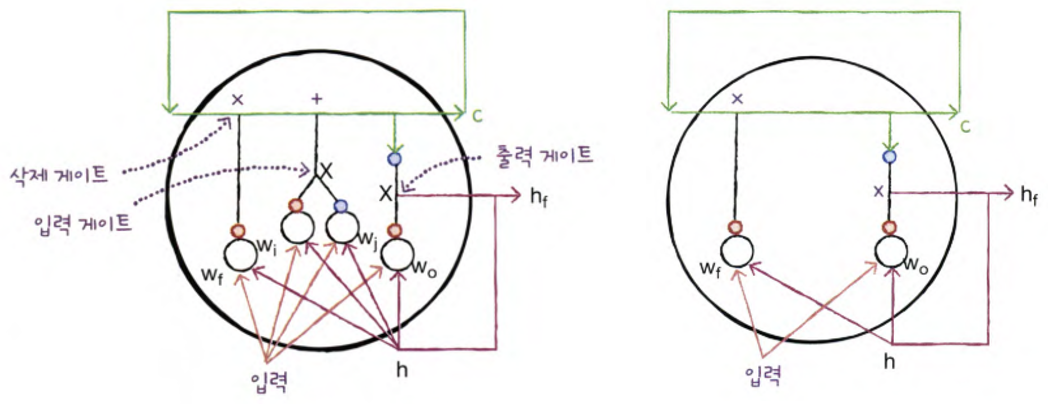
- 각 곱하기 부분은 지정된 게이트 역할을 함(삭제, 입력, 출력)
- 입력과 은닉 상태를 각각 다른 가중치에 곱함
- 결과 중 하나는 시그모이드 함수를 통과(A)하고 하나는 tanh함수를 통과(B)
- (A)와 (B)를 곱한 수 이전 셀 상태와 더하여 최종 셀 상태를 만듦

#### 게이트
- 삭제 게이트
    - 셀 상태에 있는 정보를 제거하는 역할
- 입력 게이트
    - 새로운 정보를 셀 상태에 추가하는 역할
- 출력 게이트
    - 출력 게이트를 통해 셀 상태가 이전 은닉 상태와 곱하고 다음 은닉 상태로 출력하는 역할

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## LSTM 신경망 훈련하기
- 케라스에서 제공하는 LSTM 클래스를 이용하여 LSTM순환 신경망을 만든다. 

#### 데이터 준비 및 나누기

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

X_train, X_test_val, y_train, y_test_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

#### 데이터 길이 지정
- 모자란 데이터는 패딩 적용

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen=100)
X_test_val_seq = pad_sequences(X_test_val, maxlen=100)

#### LSTM 셀을 사용하는 순환층 생성하기

In [4]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.Input(shape=(100,)))
model.add(keras.layers.Embedding(500, 16))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

##### 해석
- SimpleRNN클래스의 모델 파라미터 개수는 200개였음
- LSTM 셀에는 4개의 작은 셀이 있으므로 4배가 늘어서 800개의 모델 파라미터를 가짐

#### 모델을 컴파일하고 훈련 진행
- 이전과 동일하게 배치 크기는 64개, 에포크 횟수는 100으로 지정
- 체크포인트와 조기종료를 위한 코드도 동일하게 적용

In [5]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test_val_seq, y_test_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7600 - loss: 0

#### 그래프를 그려서 훈련 손실과 검증 손실 확인

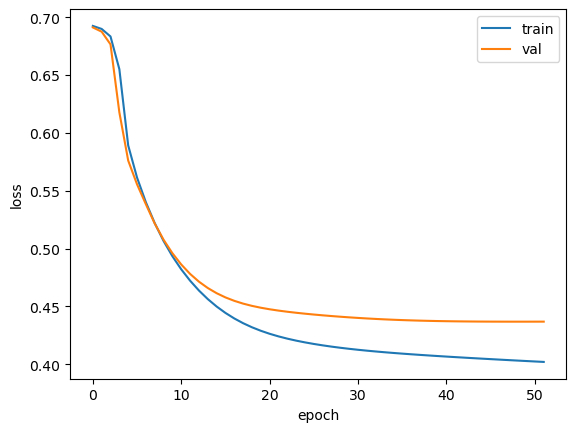

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 기본 순환층보다 비교적 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 보임
- 경우에 따라서 과대적합을 보다 강하게 제어하고자 할 경우 드랍아웃을 적용해볼 수 있음

## 순환 층에 드롭아웃 적용하기
- 완전 연결 신경망과 합성곱 신경망에서 Dropout클래스를 적용해서 훈련세트에 대한 과적합을 제어했음
- 순환층은 자체적으로 드랍아웃 기능을 제공
    - dropout, recurrent_dropout 매개변수로 설정 가능
    - dropout: 셀의 입력에 드랍아웃을 적용
    - recurrent_dropout: 순환되는 은닉상태에 드랍아웃 적용
        - 이 설정은 기술적 문제로 GPU를 사용해서 모델 훈련 불가(CPU만 사용하므로 훈련 속도가 크게 느려짐)

#### dropout 매개변수 적용
- dropout=0.3으로 지정

In [7]:
model2 = keras.Sequential()

model2.add(keras.Input(shape=(100,)))
model2.add(keras.layers.Embedding(500, 16))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

#### 드랍아웃이 설정된 모델을 이전과 동일하게 훈련 진행

In [8]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                     validation_data=(X_test_val_seq, y_test_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.6026 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7326 - loss: 0

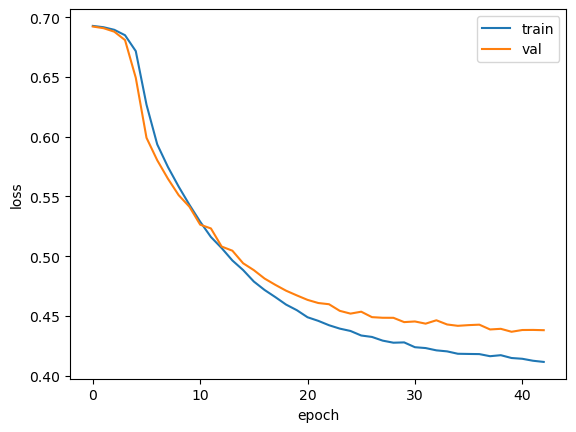

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 훈련 손실과 검증 손실 간 차이가 좁아짐
- 드랍아웃을 적용한 것이 효과가 있는 것으로 보임

## 2개의 층을 연결하기
- 밀집층이나 합성곱 층처럼 순환층도 여러 개를 쌓을 수 있음

### 순환층 연결 시 주의
- 기본적으로 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달
- 순환층을 쌓으려면 모든 순환층에 순차 데이터가 전달될 필요가 있음
- 앞쪽의 순환층에서 모든 타임스텝에 대한 은닉 상태 출력이 필요하고 마지막 순환층만 마지막 타임스텝의 은닉상태를 출력하도록 해야 함
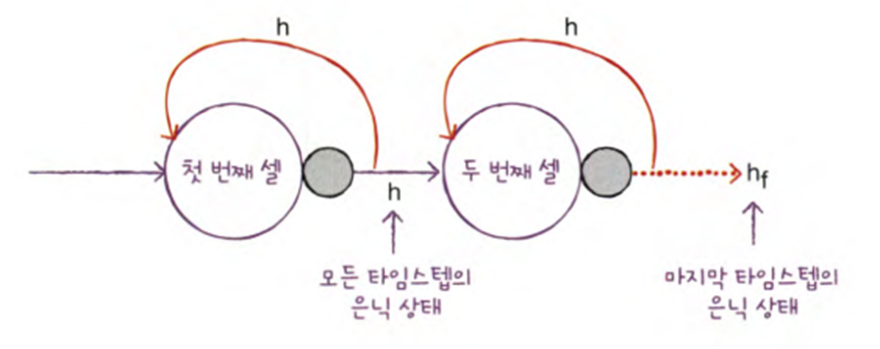
- 마지막 순환층을 제외하고 앞에 있는 순환층에 return_sequences=True 파라미터가 필요함

In [11]:
model3 = keras.Sequential()

model3.add(keras.Input(shape=(100,)))
model3.add(keras.layers.Embedding(500, 16))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

##### 설명
- 첫 번째 LSTM층이 모든 타임스텝(100개)의 은닉 상태를 출력하므로 출력 크기가 (None, 100, 8)로 표시
- 두 번째 LSTM층은 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None, 8)로 표시

#### 2개의 순환층이 있는 모델 훈련하기

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model3.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                     validation_data=(X_test_val_seq, y_test_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 108ms/step - accuracy: 0.7732 -

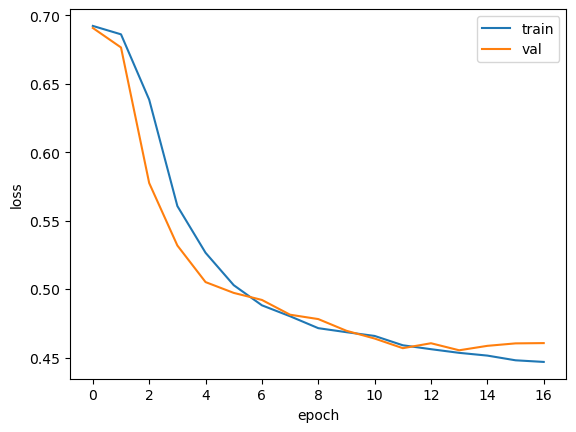

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 과대적합을 제어하면서 손실을 최대한 낮춘것으로 보여짐

## GRU(Gate Recurrent Unit) 신경망 훈련하기
- 뉴욕 대학교 조경현 교수가 발명한 셀로 유명
- LSTM을 간소화한 개념의 버전으로 볼 수 있음
- 은닉 상태 하나만 포함(LSTM은 셀 상태를 계산)
- GRU 셀은 LSTM보다 가중치가 적어 계산량이 적지만 LSTM만큼 좋은 성능을 낸다고 알려져 있음
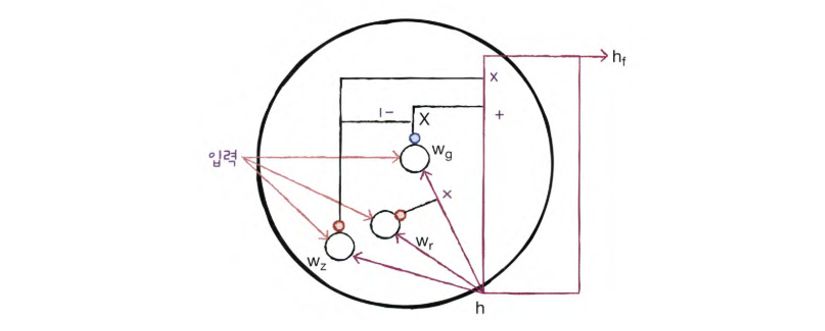

### 내부 동작
- GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있음
- 2개는 시그모이드 활성화 함수를 사용
- 1개는 tanh활성화 함수를 사용
- 그림에서는 은닉 상태와 입력에 곱해지는 가중치를 합쳐서 나타냄
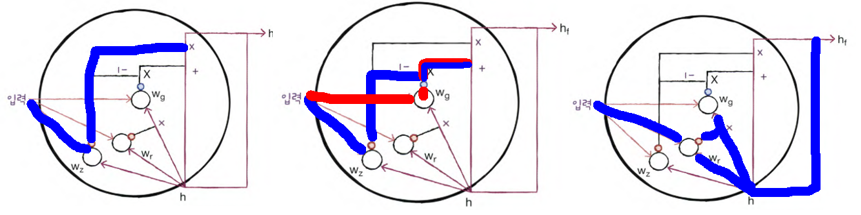
- 맨 왼쪽에서 $W_z$를 사용하는 셀의 출력이 은닉 상태에 바로 곱해져 삭제 게이트 역할을 수행
- 동일한 출력을 1에서 뺀 다음 가장 오른쪽 $W_g$를 사용하는 셀의 출력에 곱해서 입력 정보를 제어하는 역할을 수행
- 가운데 $W_r$을 사용하는 셀에서 출력된 값은 $W_g$셀이 사용할 은닉 상태의 정보를 제어하는 역할을 수행

### GRU 신경망 생성 및 훈련

In [14]:
model4 = keras.Sequential()

model4.add(keras.Input(shape=(100,)))
model4.add(keras.layers.Embedding(500, 16))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

##### 모델 파라미터 계산
- GRU 셀은 3개의 작은 셀이 있음(입력과 은닉 상태에 곱하는 가중치와 절편이 존재)
- 입력에 곱하는 가중치: 16x8=128
- 은닉 상태에 곱하는 가중치: 8x8=64
- 절편은 뉴런마다 하나씩 총 8개
- 총합 128 + 64 + 8 = 200개이고 이러한 셀이 3개이기 때문에 600개의 모델 파라미터가 만들어짐
- 텐서플로우에서 GRU구현 시 이론과 차이를 보이는 것이 24개의 모델파라미터이다. 
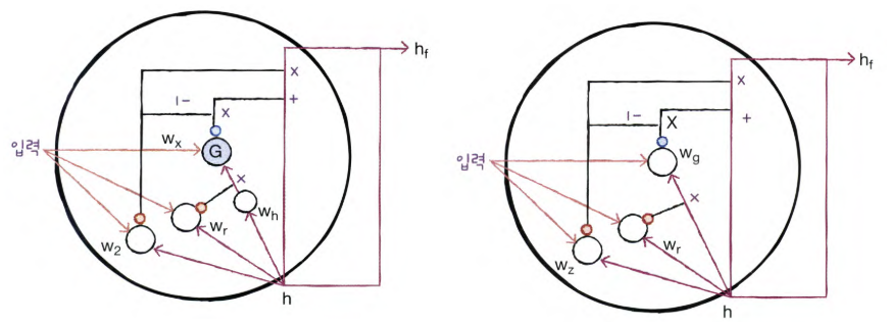
- G로 표시된 작은 셀에 들어간 입력 부분이 추가되어 있음
- 이전 그림에서는 셀의 출력과 은닉상태가 곱해진 후 G셀에 입력되는 형태
- 텐서플로우에서는 은닉상태가 먼저 가중치과 곱해진 다음 가운데 셀의 출력과 곱해짐
    - 이전에 $W_g$로 표현했던 입력과 은닉 상태에 곱해지는 가중치는 $W_x$와 $W_h$로 나누어짐
    - 따라서 가중치 외의 절편도 각각 필요하므로 작은 셀마다 하나씩 절편이 추가됨
- 8개의 뉴런이 있으므로 총 24개의 파라미터가 더해진 결과가 나옴

##### 널리 사용되는 이론과 실제 소프트웨어 구현이 차이가 있는 경우가 있음


### GRU 셀을 사용한 순환 신경망 훈련

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model4.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                     validation_data=(X_test_val_seq, y_test_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.5052 - loss: 0.6931 - val_accuracy: 0.5206 - val_loss: 0.6928
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5532 - loss: 0.6925 - val_accuracy: 0.5616 - val_loss: 0.6921
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.5831 - loss: 0.6917 - val_accuracy: 0.5714 - val_loss: 0.6911
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.5901 - loss: 0.6903 - val_accuracy: 0.5844 - val_loss: 0.6893
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.6033 - loss: 0.6882 - val_accuracy: 0.5938 - val_loss: 0.6866
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.6136 - loss: 0.6849 - val_accuracy: 0.6036 - val_loss: 0.6822
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.6197 - loss: 0.6796 - val_accuracy: 0.6120 - val_loss: 0.6752
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 72ms/step - accuracy: 0.6300 - loss: 0

##### 결과
- LSTM과 거의 비슷한 성능을 보이는 것으로 판단됨
- 그래프를 그려서 훈련 손실과 검증 손실 확인

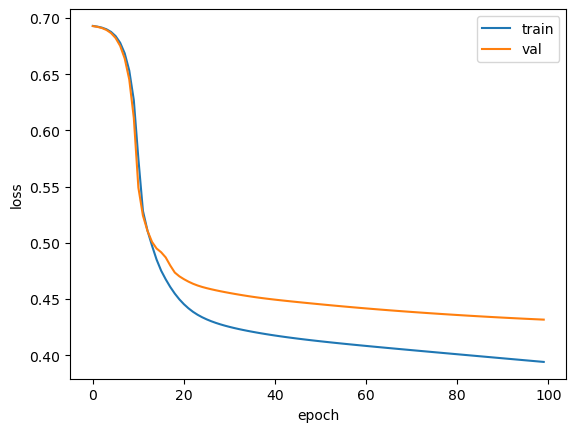

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 드랍아웃을 적용하지 않았으므로 훈련 손실과 검증 손실이 차이가 다소 있어 보임
- 훈련 과정이 잘 수렴되고 있는 것으로 보임

### Dropout 적용하여 테스트

In [17]:
model5 = keras.Sequential()

model5.add(keras.Input(shape=(100,)))
model5.add(keras.layers.Embedding(500, 16))
model5.add(keras.layers.GRU(8, dropout=0.3))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model5.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model-dropout.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model5.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                     validation_data=(X_test_val_seq, y_test_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.5090 - loss: 0.6930 - val_accuracy: 0.5196 - val_loss: 0.6926
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5332 - loss: 0.6918 - val_accuracy: 0.5370 - val_loss: 0.6914
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5527 - loss: 0.6905 - val_accuracy: 0.5440 - val_loss: 0.6900
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5665 - loss: 0.6889 - val_accuracy: 0.5540 - val_loss: 0.6879
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.5701 - loss: 0.6864 - val_accuracy: 0.5694 - val_loss: 0.6850
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.5804 - loss: 0.6829 - val_accuracy: 0.5824 - val_loss: 0.6809
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5996 - loss: 0.6778 - val_accuracy: 0.5938 - val_loss: 0.6752
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.6107 - loss: 0

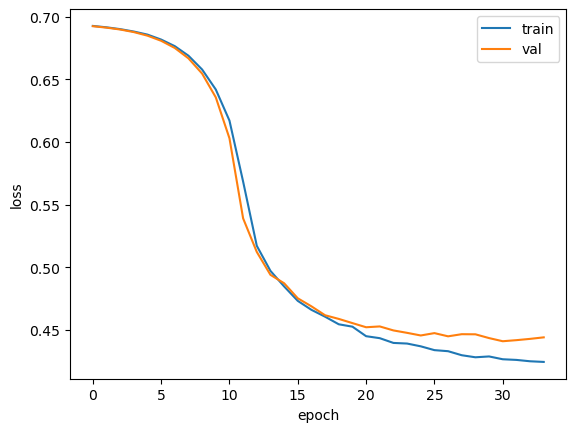

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 드랍아웃 적용 전에 비해 훈련 손실과 검증 손실이 비슷해짐

#### 지금까지 테스트 했던 모델들의 손실그래프 차이 확인
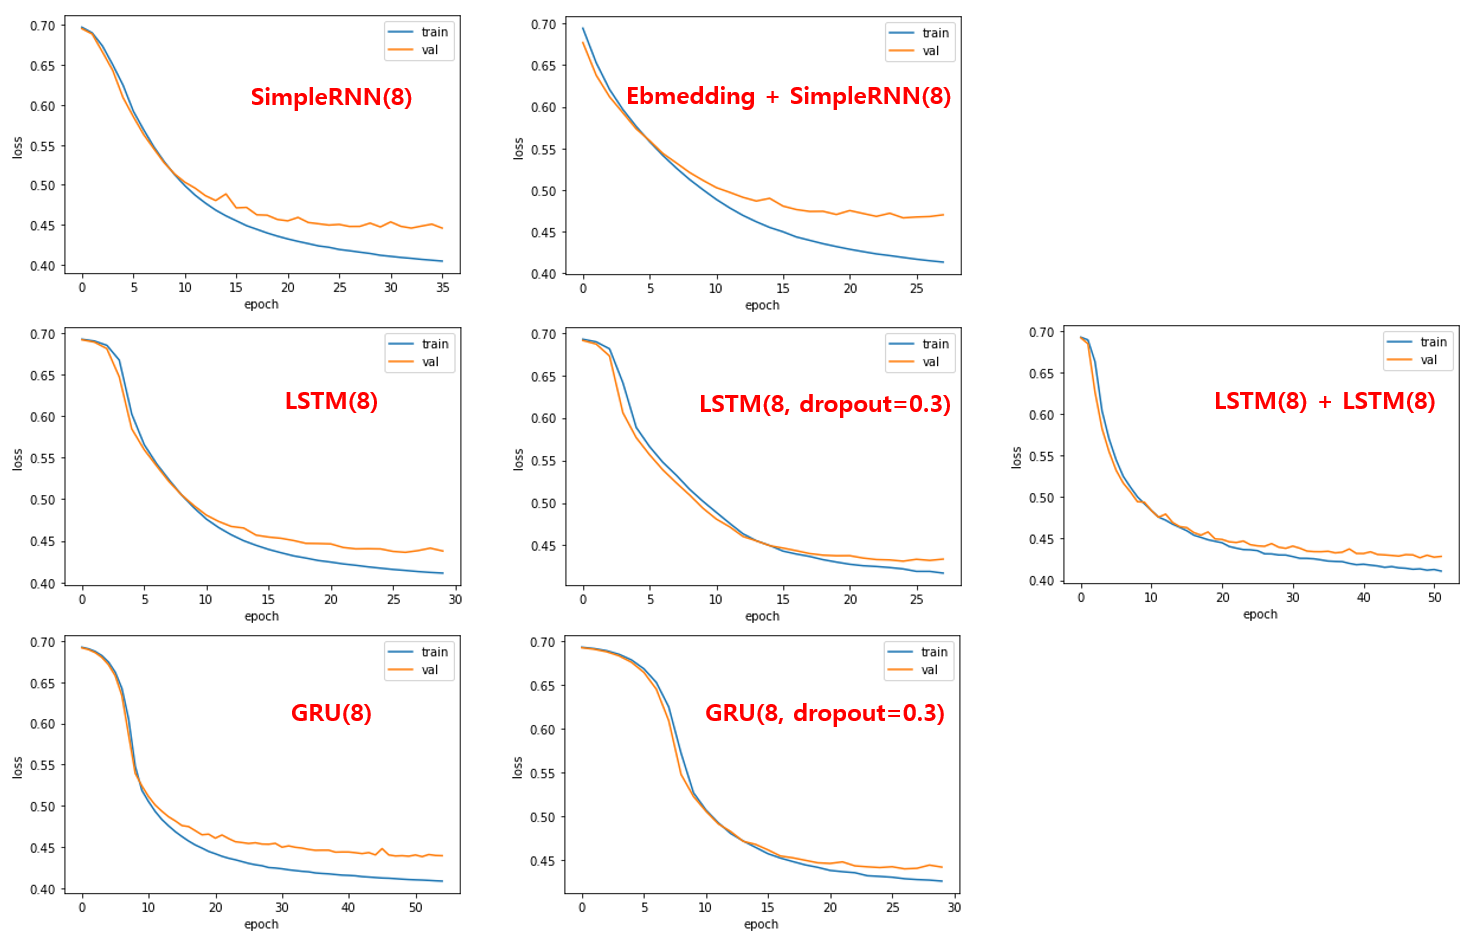
- 보다 정확한 비교를 위해서는 그래프들의 X축 단위를 맞춰서 확인이 필요할 수 있음
- 대략 그래프의 비교를 통해 어떤 모델이 좋은 성능을 보이는지 가늠해볼 수 있음

## 마무리
- 처음 떼어놨던 테스트 데이터를 100으로 자르고 모자란 데이터는 패딩을 추가한다.
- 2개의 층을 적용한 모델이 저장되어 있는 2rnn-model.keras를 불러와서 최종 테스트 진행

In [20]:
X_test_seq = pad_sequences(X_test, maxlen=100)

rnn_model = keras.models.load_model('best-2rnn-model.keras')

rnn_model.evaluate(X_test_seq, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.7877 - loss: 0.4545


[0.4543180465698242, 0.7878400087356567]